<a href="https://colab.research.google.com/github/neil-kuldip/Disproportion_of_NYC_Litter_Sanitation/blob/main/Disproportion_of_NYC_Litter_Sanitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Disproportion of NYC Litter Sanitation**
######By: Neil Kuldip

![picture](https://drive.google.com/uc?export=view&id=1bmgIr4YKpfp_T8t1jgb8psdkialdfTGi)


##**Overview of the project:**
The focus of this project is to analyze and visualize some of the visible factors around NYC excessive littering in lower-income zip codes. These factors include: New York Department of Sanitation (DSNY) Public Litter Baskets, DSNY Food Scrap Drop Off Sites, DSNY Districts, and Active Tobacco Retail Dealers. To measure these factors by zip code and income of residents per zip code, U.S. Postal Service data on zip codes, U.S. Census data on Zip Code Tabulation Areas and 5-Year Median Income was utilized. In order to measure the amount of excessive litter, DSNY reports on Monthly Tonnage and Scorecard Ratings of Acceptable Cleanliness of Streets and Sidewalks were reviewed. After filtering, cleaning, and using feature engineering to create columns for merging datasets, I was able to conduct my analysis. I predicted that the zip codes that contained above average median incomes would have a higher density in DSNY resources. I also expected there would be a high correlation among the factors and with the measures of the excessive litter. 

##**Data**
For zip code, the U.S. Postal Service Zip Code Database and the U.S. Census Bureau Zip Code Tabulation Areas datasets were used. The postal service database is a collection of postal zip codes used by the USPS to route mail more efficiently, sorted by county to get NYC zip codes. The Census dataset contained shapefile data for each of these zip codes. For income, the American Community Survey (ACS) 2019 Income in the Past 12 Months (5-Year Estimates) was used. This data featured the median income estimates of each ZCTA in the U.S. categorized into households, family, married-couples, and non-family incomes. For sanitation resources and measures, DSNY Litter Basket Inventory, Food Scrap Drop Off Locations in NYC, Districts, Monthly Tonnage Data, and Scorecard Ratings were applied. Litter Basket Inventory contains spatial data on all public basket locations and types in NYC. Food Scrap Drop Off Locations in NYC has spatial data on all locations where residents can drop off their food scraps to be composted. Districts is a shapefile of the 59 sanitation districts for operation management. Monthly Tonnage Data provides monthly collection tonnages that the DSNY collects from NYC residences and institutions. Scorecard Ratings is a monthly report on NYC street and sidewalk cleanliness. To inspect cigarette litter, Active Tobacco Retail Dealer Licenses were used. This is a collection of all businesses/individuals holding an active DCA license to sell tobacco products.    


##Techniques

**Zip Code:**
Since NYC specific zip codes were needed, I filtered the data by counties: New York (Manhattan), Queens, Kings (Brooklyn), Richmond (Staten Island), and Bronx. Then to get the spatial data, the Census ZCTA was condensed to zipcodes whose numeric values were under 11700 and then inner joined the tables with pandas to make a working zip code dataframe. 

**Income:**
I reorganzied the dataframe to be queried by changing the columns. After formatting the zip code dataframe for later merging, I took each median income from households, family, married-couples, and non-family and computed the averages for each zip code under "income" and created a categorical feature, "income_category" to break up the average median income range into sections of $20,000 with regular expressions. I proceeded to left join merge and created a zip code - income dataframe, preserving the zip codes. 

**Litter Basket & Food Scrap Sites:** 
For DSNY datasets, the data was not originally sorted by zip code but only through operational district and community districts. I created getDistrictZip(), getZip(), and getZipDistrict() that all iterated through the district, litter basket, and zip code dataframes to obtain the missing information that each set was lacking through the use of shapely.polygon overlaps() and within(). I was then able to group the baskets and drop off sites by the zip code they reside in and merged them to the zip code - income dataframe.

**Spatial Data Map:** 
To visualize the litter baskets, food drop off sites, zip code, and DSNY districts, I used Folium to create a map to see these features. I proceeded to create a getXCoord() and getYCoord() for the csv datasets to extract the locations. Using Folium markercluster classes, I created markers for both the litter baskets and food drop off sites to place in the map. Then added the shapefile polygons of the ZCTA data and DSNY district as separate layers.

**Bar & Pie Graphs:**
To check the validation of some of my predictions, I used Seaborn and Matplotlib to create a bar plot that showed the top 20 zip codes with the highest density of public litter baskets through sorting the number of baskets in ascending order. There I also created a pie chart of the percentages of existing food scrap drop off sites by getting the percentages of sites per zip code over the total.

**Cigarette Retail Dealers:** 
For tobacco retail dealer licenses data, I wanted to analyze if there was a correlation between the number of active cigarette sellers in a zip code to other aspects of litter resources and measurements. I sorted the dealer dataframe for relevant columns such as business name, zip code, and spatial data. There I grouped the data by zip code and left joined this to the main dataframe.

**Monthly Tonnage:**
I performed the same routine with the other DSNY datasets and made a column for community district and sorted the dataframe for columns in district and different parts of garbage collection. I first merged it with the DSNY district dataframe to configure if there were food scrap sites per each district with zipScrapSite(). Then I merged this with the main dataframe on a left join with zip code. 

**Scorecard Ratings:**
I dropped the other columns that do not pertain to district and current month's rating and grouped by district. I then merged this to the main dataframe through district associated to the zip code. 

**Correlation Heatmap & Linear Regression Models:**
From there I created a heatmap with Seaborn on the correlation matrix between income, litter baskets, drop off sites, tobacco sellers, types of garbage collected, and scorecard ratings. This would help to make connections to compare to the rest of my hypothesis. Noticing out of the factors, the number of cigarette sellers to number of baskets had a higher correlation compared to the others. I used sklearn's train_test_split and statsmodel to train and create the linear regression model. Using the r-squared value, I was able to determine how much of the variance in number of baskets can be explained by the number of cigarette sellers.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import pandasql as psql
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datapane as dp
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from IPython.display import display, Image, IFrame 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Combining Zip Code Database with Associated Polygons

######Loading zip code database

In [141]:
df = pd.read_csv("/content/drive/MyDrive/DS_Project_Files/zip_code_database.csv")

In [142]:
nyc_counties = ["Richmond County", "Kings County", "Queens County", 
                "Bronx County", "New York County"]
col_filt = ["zip", "county", "state", "longitude", "latitude"]
zip_code_boolean = df.county.isin(nyc_counties)
state_boolean = df.state.isin(["NY"])
df = df[zip_code_boolean] 
df = df[state_boolean]
zip_df = df[col_filt]
zip_df = zip_df.reset_index(drop=True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population
3757,10001,STANDARD,0,New York,NaN,"Empire State, Gpo, Greeley Square, Macys Finan...",NY,New York County,America/New_York,"718,917,347,646",NaN,US,40.75,-74.00,21760
3758,10002,STANDARD,0,New York,Knickerbocker,"Manhattan, New York City, NY, Ny City, Nyc",NY,New York County,America/New_York,718,NaN,US,40.71,-73.99,67080
3759,10003,STANDARD,0,New York,NaN,"Cooper, Manhattan, New York City, NY, Ny City,...",NY,New York County,America/New_York,"212,347,646,718,917",NaN,US,40.73,-73.99,38080
3760,10004,STANDARD,0,New York,Bowling Green,"Manhattan, New York City, NY, Ny City, Nyc",NY,New York County,America/New_York,"212,347,646,718,917",NaN,US,40.69,-74.02,4280
3761,10005,STANDARD,0,New York,Wall Street,"Manhattan, New York City, NY, Ny City, Nyc",NY,New York County,America/New_York,"347,718,212,646,917",NaN,US,40.71,-74.01,8280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4326,11692,STANDARD,0,Arverne,Far Rockaway,Queens,NY,Queens County,America/New_York,"347,929,718",NaN,US,40.59,-73.79,16850
4327,11693,STANDARD,0,Far Rockaway,"Broad Channel, Rockaway Bch, Rockaway Beach",Queens,NY,Queens County,America/New_York,718,NaN,US,40.59,-73.81,10310
4328,11694,STANDARD,0,Rockaway Park,"Belle Harbor, Far Rockaway, Neponsit",Queens,NY,Queens County,America/New_York,718,NaN,US,40.58,-73.84,15680
4329,11695,PO BOX,0,Far Rockaway,Fort Tilden,Queens,NY,Queens County,America/New_York,212,NaN,US,40.59,-73.81,30


######Getting geodataframes for merging zip code with associated polygon data

In [143]:
zip_gdf = gpd.GeoDataFrame(zip_df)
ZCTA = gpd.read_file("/content/drive/MyDrive/DS_Project_Files/Census_ZCTA5/Census_ZCTA5.shp")
ZCTA

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,47236,47236,B5,G6350,S,1029067,0,+39.1517426,-085.7252769,"POLYGON ((-85.73410 39.15597, -85.72749 39.156..."
1,47870,47870,B5,G6350,S,8830,0,+39.3701518,-087.4735141,"POLYGON ((-87.47414 39.37016, -87.47409 39.370..."
2,47851,47851,B5,G6350,S,53547,0,+39.5735818,-087.2459626,"POLYGON ((-87.24770 39.57431, -87.24770 39.574..."
3,47337,47337,B5,G6350,S,303089,0,+39.8027537,-085.4372850,"POLYGON ((-85.44357 39.80328, -85.44346 39.803..."
4,47435,47435,B5,G6350,S,13302,0,+39.2657557,-086.2951577,"POLYGON ((-86.29592 39.26547, -86.29592 39.266..."
...,...,...,...,...,...,...,...,...,...,...
33786,37932,37932,B5,G6350,S,75093217,4374995,+35.9172993,-084.1987873,"POLYGON ((-84.27347 35.93928, -84.27287 35.940..."
33787,37341,37341,B5,G6350,S,87434962,27139990,+35.2199309,-085.0730025,"POLYGON ((-85.15090 35.11231, -85.15088 35.112..."
33788,37849,37849,B5,G6350,S,102931713,896866,+36.0540502,-084.0484876,"POLYGON ((-84.14857 36.04234, -84.14240 36.046..."
33789,37754,37754,B5,G6350,S,99003113,145391,+36.1390993,-084.0298007,"POLYGON ((-84.10549 36.11168, -84.10543 36.111..."


######ZCTA --> Zip Code Tabulation Areas
######Filtering the large ZCTA dataset to NYC ZCTAs and having one main geodataframe
######Highest NYC zip code numerical number in zip_df is 11697, so condensing the size of the dataset we need with ZCTA["ZCTA5CE20"] < 11700

In [144]:
ZCTA["ZCTA5CE20"] = ZCTA["ZCTA5CE20"].astype(int)
ZCTA = ZCTA[ZCTA["ZCTA5CE20"] < 11700]

ZCTA = ZCTA.rename({"ZCTA5CE20" : "zip"}, axis=1)
ZCTA = ZCTA[["zip", "geometry"]]
ZCTA_zip_gdf = pd.merge(zip_gdf, ZCTA, how="inner", on="zip")
ZCTA_zip_gdf = ZCTA_zip_gdf.reset_index(drop=True)
ZCTA_zip_gdf

,zip,county,state,longitude,latitude,geometry
0,10001,New York County,NY,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752..."
1,10002,New York County,NY,-73.99,40.71,"POLYGON ((-73.99750 40.71407, -73.99709 40.714..."
2,10003,New York County,NY,-73.99,40.73,"POLYGON ((-73.99937 40.73132, -73.99911 40.731..."
3,10004,New York County,NY,-74.02,40.69,"MULTIPOLYGON (((-74.01769 40.70386, -74.01765 ..."
4,10005,New York County,NY,-74.01,40.71,"POLYGON ((-74.01251 40.70677, -74.01195 40.707..."
...,...,...,...,...,...,...
206,11691,Queens County,NY,-73.76,40.60,"POLYGON ((-73.78926 40.59651, -73.78925 40.596..."
207,11692,Queens County,NY,-73.79,40.59,"POLYGON ((-73.80533 40.59052, -73.80452 40.590..."
208,11693,Queens County,NY,-73.81,40.59,"MULTIPOLYGON (((-73.82009 40.58698, -73.81936 ..."
209,11694,Queens County,NY,-73.84,40.58,"POLYGON ((-73.88305 40.56838, -73.88294 40.568..."


##Filtering ACS(5-Year) Data for Median Income by Zip Code

#####Loading Median Income Data (ACS(5-Year))

In [145]:
acs_df = pd.read_csv("/content/drive/MyDrive/DS_Project_Files/ACS(5-Year)_2019/ACS(5-Year)_2019.csv")

######Format df columns to be the description of the columns (first row)

In [146]:
header_row = 0
acs_df.columns = acs_df.iloc[header_row]
acs_df = acs_df.drop(header_row)
acs_df = acs_df.reset_index(drop=True)

######Filtering column names for:
- zipcode, 
- household median income, 
- family median income,
- married-couple median income, and 
- non-family median income

In [147]:
relevant_col = ["Geographic Area Name"]
relevant_col += [x for x in acs_df.columns if (("Median income" in x) and ("Estimate" in x))]
relevant_col

['Geographic Area Name',
 'Estimate!!Households!!Median income (dollars)',
 'Estimate!!Families!!Median income (dollars)',
 'Estimate!!Married-couple families!!Median income (dollars)',
 'Estimate!!Nonfamily households!!Median income (dollars)']

#####List of nyc_zipcodes to filter df

In [148]:
nyc_zip_codes = list(zip_df.zip)
nyc_zip_codes = [str(x) for x in nyc_zip_codes]

#####Cleaning NA data with zeros for average function

In [149]:
median_income_df = acs_df[relevant_col].replace("-", "0")


#####Returns just the zip_code in the column cell
#####Ex: ZCTA5 10001 -> 10001

In [150]:
def onlyZip(string):
    zip_code = string[6:]
    if (len(zip_code) == 4):
        zip_code = "0" + str(zip_code)
    return zip_code

#####Clean zip_code column and filters for only nyc zip codes 

In [151]:
new_cols = ["zip_code", "household", "family", "married_couple", "non-family"]
median_income_df.columns = new_cols

median_income_df["zip_code"] = median_income_df["zip_code"].apply(onlyZip)
zip_code_boolean = median_income_df["zip_code"].isin(nyc_zip_codes)
median_income_df = median_income_df[zip_code_boolean]
median_income_df = median_income_df.reset_index(drop=True)

#####Create income range categorical data based off the average of each median income
#####Data contains $250,000+ as values in some of the columns

In [152]:
median_average = []
median_average_numeric = []
for x in median_income_df.index:
    high_income = r'250,000\+'
    temp = " ".join(list(median_income_df.iloc[x]))
    if (re.search(high_income, temp)):
        median_average.append("$200,000+")
        median_average_numeric.append(np.Inf)
    else:
        household = int(median_income_df.loc[x, "household"])
        family = int(median_income_df.loc[x, "family"])
        married_couple = int(median_income_df.loc[x, "married_couple"])
        non_family = int(median_income_df.loc[x, "non-family"])
        average = (household + family + married_couple + non_family)/4
        if (average == 0):
            median_average.append("N/A")
            median_average_numeric.append(0)
        elif (average < 20000):
            median_average.append("$1-19,999")
            median_average_numeric.append(average)
        elif (average < 40000):
            median_average.append("$20,000-39,999")
            median_average_numeric.append(average)
        elif (average < 60000):
            median_average.append("$40,000-59,999")
            median_average_numeric.append(average)
        elif (average < 80000):
            median_average.append("$60,000-79,999")
            median_average_numeric.append(average)
        elif (average < 100000):
            median_average.append("$80,000-99,999")
            median_average_numeric.append(average)
        elif (average < 120000):
            median_average.append("$100,000-119,999")
            median_average_numeric.append(average)
        elif (average < 140000):
            median_average.append("$120,000-139,999")
            median_average_numeric.append(average)
        elif (average < 160000):
            median_average.append("$140,000-159,999")
            median_average_numeric.append(average)
        elif (average < 180000):
            median_average.append("$160,000-179,999")
            median_average_numeric.append(average)
        elif (average < 200000):
            median_average.append("$180,000-199,999")
            median_average_numeric.append(average)
        else:
            median_average.append("$200,000+")
            median_average_numeric.append(np.Inf)

median_income_df = median_income_df.assign(income_category = median_average, 
                                           income= median_average_numeric)
median_income_df

,zip_code,household,family,married_couple,non-family,income_category,income
0,10001,92840,122776,158917,85785,"$100,000-119,999",115079.50
1,10002,36982,40045,43952,31767,"$20,000-39,999",38186.50
2,10003,118161,183787,193778,95812,"$140,000-159,999",147884.50
3,10004,190223,205202,204657,150833,"$180,000-199,999",187728.75
4,10005,189702,241094,239800,180389,"$200,000+",inf
...,...,...,...,...,...,...,...
206,11691,50267,61360,79103,23790,"$40,000-59,999",53630.00
207,11692,46819,50516,91434,33153,"$40,000-59,999",55480.50
208,11693,60569,66250,86184,41178,"$60,000-79,999",63545.25
209,11694,84485,111046,135208,50061,"$80,000-99,999",95200.00


#####Using pandasql queries to merge zip code df and income df 

In [153]:
query = """
SELECT *
FROM median_income_df as M
INNER JOIN zip_df as Z
ON M.zip_code = Z.zip
""" 
zip_income_df = psql.sqldf(query)        
zip_income_df = zip_income_df.drop(["household", "family", "married_couple", "non-family", "zip", "state"], axis=1)
zip_income_df

,zip_code,income_category,income,county,longitude,latitude
0,10001,"$100,000-119,999",115079.50,New York County,-74.00,40.75
1,10002,"$20,000-39,999",38186.50,New York County,-73.99,40.71
2,10003,"$140,000-159,999",147884.50,New York County,-73.99,40.73
3,10004,"$180,000-199,999",187728.75,New York County,-74.02,40.69
4,10005,"$200,000+",inf,New York County,-74.01,40.71
...,...,...,...,...,...,...
206,11691,"$40,000-59,999",53630.00,Queens County,-73.76,40.60
207,11692,"$40,000-59,999",55480.50,Queens County,-73.79,40.59
208,11693,"$60,000-79,999",63545.25,Queens County,-73.81,40.59
209,11694,"$80,000-99,999",95200.00,Queens County,-73.84,40.58


######Using pandas merge to obtain geodataframe version of zip_income.df

In [154]:
median_income_gdf = gpd.GeoDataFrame(median_income_df)
median_income_gdf = median_income_gdf.rename({"zip_code" : "zip"}, axis=1)
median_income_gdf["zip"] = median_income_gdf["zip"].astype(int)
ZCTA_income_gdf = pd.merge(ZCTA_zip_gdf, median_income_gdf, how="left", on="zip")
ZCTA_income_gdf = ZCTA_income_gdf.drop(["household", "family", "married_couple", "non-family", "state"], axis=1)
ZCTA_income_gdf

,zip,county,longitude,latitude,geometry,income_category,income
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.50
1,10002,New York County,-73.99,40.71,"POLYGON ((-73.99750 40.71407, -73.99709 40.714...","$20,000-39,999",38186.50
2,10003,New York County,-73.99,40.73,"POLYGON ((-73.99937 40.73132, -73.99911 40.731...","$140,000-159,999",147884.50
3,10004,New York County,-74.02,40.69,"MULTIPOLYGON (((-74.01769 40.70386, -74.01765 ...","$180,000-199,999",187728.75
4,10005,New York County,-74.01,40.71,"POLYGON ((-74.01251 40.70677, -74.01195 40.707...","$200,000+",inf
...,...,...,...,...,...,...,...
206,11691,Queens County,-73.76,40.60,"POLYGON ((-73.78926 40.59651, -73.78925 40.596...","$40,000-59,999",53630.00
207,11692,Queens County,-73.79,40.59,"POLYGON ((-73.80533 40.59052, -73.80452 40.590...","$40,000-59,999",55480.50
208,11693,Queens County,-73.81,40.59,"MULTIPOLYGON (((-73.82009 40.58698, -73.81936 ...","$60,000-79,999",63545.25
209,11694,Queens County,-73.84,40.58,"POLYGON ((-73.88305 40.56838, -73.88294 40.568...","$80,000-99,999",95200.00


##Calculating Public Litter Basket & Public Food Waste Drop Off Site Density by Zip Code

In [155]:
litter_basket_gdf = gpd.read_file("/content/drive/MyDrive/DS_Project_Files/DSNY_Litter_Basket_Inventory/litter_basket_inventory.shp")
dsny_districts_gdf = gpd.read_file("/content/drive/MyDrive/DS_Project_Files/DSNY_Districts/dsny_districts.shp")
food_scraps_gdf = gpd.read_file("/content/drive/MyDrive/DS_Project_Files/Food_Scrap_Drop-Off_Locations_in_NYC/food_scrap_drop_off_locations.shp")

In [156]:
def getDistrictZip(district):
    """
    function that returns a list of zip codes whose polgyons overlap with the given DNSY district's polygon to
    determine which zip codes are a part of the DSNY district

    Parameters
    ----------
    district : shapely.geometry.polygon.Polygon
        DSNY district as shapely polygon object

    Returns
    -------
    list of string values
        Zip codes that overlap (are a part of) the given district
    str
        nan if no overlap is found
    """
    result = []
    for x in ZCTA_income_gdf.index:
        if district.overlaps(ZCTA_income_gdf.loc[x, "geometry"]):
            result.append(ZCTA_income_gdf.loc[x, "zip"])
    if len(result) == 0:
        return np.nan
    else:
        return result

In [157]:
def getZip(basket):
    """
    function that returns the zip code in the location of the given litter basket by checking
    if the point is within the zipcode polygon

    Parameters
    ----------
    basket : shapely.geometry.point.Point
        NYC public litter basket as shapely polygon object

    Returns
    -------
    str
       name of Zip code in the location of the litter basket, nan if not found 

    """
    for x in ZCTA_income_gdf.index:
        if basket.within(ZCTA_income_gdf.loc[x, "geometry"]):
            return(ZCTA_income_gdf.loc[x, "zip"])
    return np.nan     

#####Using the functions to retrieve zip codes for districts, baskets, and food scrap sites

In [158]:
dsny_districts_gdf["zipcode"] = dsny_districts_gdf["geometry"].apply(getDistrictZip)
litter_basket_gdf["zipcode"] = litter_basket_gdf["geometry"].apply(getZip)
food_scraps_gdf["zipcode"] = food_scraps_gdf["geometry"].apply(getZip)

#####Aggregating geodataframe to count number of baskets per zip code

In [159]:
grouped_basket_gdf = litter_basket_gdf.assign()
grouped_basket_gdf = grouped_basket_gdf.groupby("zipcode").count()
grouped_basket_gdf = grouped_basket_gdf.reset_index()
grouped_basket_gdf = grouped_basket_gdf.rename({"basketid" : "num_baskets", "zipcode": "zip"}, axis=1)
grouped_basket_gdf = grouped_basket_gdf[["zip", "num_baskets"]]
grouped_basket_gdf

,zip,num_baskets
0,10001.0,307
1,10002.0,280
2,10003.0,410
3,10004.0,61
4,10005.0,41
...,...,...
196,11451.0,6
197,11691.0,73
198,11692.0,32
199,11693.0,57


#####Sub geodataframe of the main one comparing zip code to income and litter baskets

In [160]:
zipcode_income_basket_gdf = pd.merge(ZCTA_income_gdf, grouped_basket_gdf, how="left", on="zip")
zipcode_income_basket_gdf

,zip,county,longitude,latitude,geometry,income_category,income,num_baskets
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.50,307.0
1,10002,New York County,-73.99,40.71,"POLYGON ((-73.99750 40.71407, -73.99709 40.714...","$20,000-39,999",38186.50,280.0
2,10003,New York County,-73.99,40.73,"POLYGON ((-73.99937 40.73132, -73.99911 40.731...","$140,000-159,999",147884.50,410.0
3,10004,New York County,-74.02,40.69,"MULTIPOLYGON (((-74.01769 40.70386, -74.01765 ...","$180,000-199,999",187728.75,61.0
4,10005,New York County,-74.01,40.71,"POLYGON ((-74.01251 40.70677, -74.01195 40.707...","$200,000+",inf,41.0
...,...,...,...,...,...,...,...,...
206,11691,Queens County,-73.76,40.60,"POLYGON ((-73.78926 40.59651, -73.78925 40.596...","$40,000-59,999",53630.00,73.0
207,11692,Queens County,-73.79,40.59,"POLYGON ((-73.80533 40.59052, -73.80452 40.590...","$40,000-59,999",55480.50,32.0
208,11693,Queens County,-73.81,40.59,"MULTIPOLYGON (((-73.82009 40.58698, -73.81936 ...","$60,000-79,999",63545.25,57.0
209,11694,Queens County,-73.84,40.58,"POLYGON ((-73.88305 40.56838, -73.88294 40.568...","$80,000-99,999",95200.00,99.0


#####Aggregating geodataframe to count number of food scrap sites per zip code

In [161]:
grouped_scraps_gdf = food_scraps_gdf.assign()
grouped_scraps_gdf = grouped_scraps_gdf.groupby("zipcode").count()
grouped_scraps_gdf = grouped_scraps_gdf.reset_index()
grouped_scraps_gdf = grouped_scraps_gdf.rename({"object_id" : "num_sites", "zipcode": "zip"}, axis=1)
grouped_scraps_gdf = grouped_scraps_gdf[["zip", "num_sites"]]
grouped_scraps_gdf

,zip,num_sites
0,10001.0,2
1,10002.0,2
2,10003.0,2
3,10004.0,5
4,10009.0,3
...,...,...
86,11426.0,1
87,11432.0,1
88,11434.0,1
89,11435.0,2


#####Main geodataframe for comparing income to:
- Number of publicly available litter baskets
- Number of publicly available food waste drop off sites
- Averge median income 

Replacing nan values for later analysis


In [162]:
zipcode_income_basket_scrap_gdf = pd.merge(zipcode_income_basket_gdf, grouped_scraps_gdf, how="left", on="zip")
zipcode_income_basket_scrap_gdf["num_baskets"] = zipcode_income_basket_scrap_gdf["num_baskets"].replace(np.nan, 0)
zipcode_income_basket_scrap_gdf["num_sites"] = zipcode_income_basket_scrap_gdf["num_sites"].replace(np.nan, 0)
zipcode_income_basket_scrap_gdf


,zip,county,longitude,latitude,geometry,income_category,income,num_baskets,num_sites
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.50,307.0,2.0
1,10002,New York County,-73.99,40.71,"POLYGON ((-73.99750 40.71407, -73.99709 40.714...","$20,000-39,999",38186.50,280.0,2.0
2,10003,New York County,-73.99,40.73,"POLYGON ((-73.99937 40.73132, -73.99911 40.731...","$140,000-159,999",147884.50,410.0,2.0
3,10004,New York County,-74.02,40.69,"MULTIPOLYGON (((-74.01769 40.70386, -74.01765 ...","$180,000-199,999",187728.75,61.0,5.0
4,10005,New York County,-74.01,40.71,"POLYGON ((-74.01251 40.70677, -74.01195 40.707...","$200,000+",inf,41.0,0.0
...,...,...,...,...,...,...,...,...,...
206,11691,Queens County,-73.76,40.60,"POLYGON ((-73.78926 40.59651, -73.78925 40.596...","$40,000-59,999",53630.00,73.0,1.0
207,11692,Queens County,-73.79,40.59,"POLYGON ((-73.80533 40.59052, -73.80452 40.590...","$40,000-59,999",55480.50,32.0,0.0
208,11693,Queens County,-73.81,40.59,"MULTIPOLYGON (((-73.82009 40.58698, -73.81936 ...","$60,000-79,999",63545.25,57.0,0.0
209,11694,Queens County,-73.84,40.58,"POLYGON ((-73.88305 40.56838, -73.88294 40.568...","$80,000-99,999",95200.00,99.0,0.0


#####Creating a function to add district to the main geodataframe to connect zip codes to DSNY districts
Applying the function

In [163]:
def getZipDistrict(zipcode):
    """
    function that returns the DSNY distict whose polgyons overlap with the given zipcode's polygon to
    determine which district is the zip code in

    Parameters
    ----------
    zipcode : shapely.geometry.polygon.Polygon
        DSNY district as shapely polygon object

    Returns
    -------
    str
        district that overlap (are a part of) the given zipcode
    str
        N/A if no overlap is found
    """
    for x in dsny_districts_gdf.index:
        if zipcode.overlaps(dsny_districts_gdf.loc[x, "geometry"]):
            return (dsny_districts_gdf.loc[x, "district"])
    else:
        return np.nan

In [164]:
zipcode_income_basket_scrap_gdf["district"] = zipcode_income_basket_scrap_gdf["geometry"].apply(getZipDistrict)
zipcode_income_basket_scrap_gdf

,zip,county,longitude,latitude,geometry,income_category,income,num_baskets,num_sites,district
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.50,307.0,2.0,MN04
1,10002,New York County,-73.99,40.71,"POLYGON ((-73.99750 40.71407, -73.99709 40.714...","$20,000-39,999",38186.50,280.0,2.0,MN03
2,10003,New York County,-73.99,40.73,"POLYGON ((-73.99937 40.73132, -73.99911 40.731...","$140,000-159,999",147884.50,410.0,2.0,MN06
3,10004,New York County,-74.02,40.69,"MULTIPOLYGON (((-74.01769 40.70386, -74.01765 ...","$180,000-199,999",187728.75,61.0,5.0,MN01
4,10005,New York County,-74.01,40.71,"POLYGON ((-74.01251 40.70677, -74.01195 40.707...","$200,000+",inf,41.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
206,11691,Queens County,-73.76,40.60,"POLYGON ((-73.78926 40.59651, -73.78925 40.596...","$40,000-59,999",53630.00,73.0,1.0,QE14
207,11692,Queens County,-73.79,40.59,"POLYGON ((-73.80533 40.59052, -73.80452 40.590...","$40,000-59,999",55480.50,32.0,0.0,QE14
208,11693,Queens County,-73.81,40.59,"MULTIPOLYGON (((-73.82009 40.58698, -73.81936 ...","$60,000-79,999",63545.25,57.0,0.0,QE14
209,11694,Queens County,-73.84,40.58,"POLYGON ((-73.88305 40.56838, -73.88294 40.568...","$80,000-99,999",95200.00,99.0,0.0,QE14


##Spatial Data Map Creation

In [165]:
def getXCoord(point):
    """
    function that returns the x coordinate of a point object passed in as a string

    Parameters
    ----------
    point : string of Point class object
        Ex: "POINT (-73.79488819299996 40.79252126700004)"

    Returns
    -------
    string of x coordinate (Longitude)
        Ex return: "-73.79488819299996"

    """
    coord = point
    coord = coord.split(" ")
    x_coord = coord[1][1:]
    return float(x_coord)

In [166]:
def getYCoord(point):
    """
    function that returns the y coordinate of a point object passed in as a string

    Parameters
    ----------
    point : string of Point class object
        Ex: "POINT (-73.79488819299996 40.79252126700004)"

    Returns
    -------
    string of y coordinate (Latitude)
        Ex return: "40.79252126700004"

    """
    coord = point
    coord = coord.split(" ")
    y_coord = coord[2][:-1]
    return float(y_coord)

######Creation of analysis_map to compare features, centered on NYC

In [167]:
analysis_map = folium.Map(
    location=[40.730610, -73.935242],
    tiles='cartodbpositron',
    zoom_start=11)
folium.TileLayer('OpenStreetMap').add_to(analysis_map)
analysis_map

#####Note: Seems easier to create MarkerCluster class with locations from .csv file than .shp
#####Start of cleaning, filtering, and extracting location data of public litter baskets

In [168]:
litter_baskets = pd.read_csv("/content/drive/MyDrive/DS_Project_Files/DSNY_Litter_Basket_Inventory/DSNY_Litter_Basket_Inventory.csv")
basket_gdf = gpd.GeoDataFrame(litter_baskets[["SECTION", "BASKETTYPE", "point"]])

#####Applying functions to get the coordinates

In [169]:
basket_gdf["Long"] = basket_gdf["point"].apply(getXCoord)
basket_gdf["Lat"] = basket_gdf["point"].apply(getYCoord)
basket_gdf

,SECTION,BASKETTYPE,point,Long,Lat
0,QE078,H,POINT (-73.79488819299996 40.79252126700004),-73.794888,40.792521
1,QE083,R,POINT (-73.81949439499994 40.73456626300003),-73.819494,40.734566
2,BX071,H,POINT (-73.90348256799996 40.86820017500003),-73.903483,40.868200
3,MN061,S,POINT (-73.98010683599995 40.73861667800003),-73.980107,40.738617
4,BX121,S,POINT (-73.86738843799998 40.87125820800003),-73.867388,40.871258
...,...,...,...,...,...
23214,BX062,S,POINT (-73.88557818999993 40.84449742900006),-73.885578,40.844497
23215,MN081,S,POINT (-73.96802895699994 40.76855951300007),-73.968029,40.768560
23216,BX071,H,POINT (-73.90158499599995 40.86254218400006),-73.901585,40.862542
23217,BKN014,S,POINT (-73.96118728899995 40.70850006200004),-73.961187,40.708500


#####Adding each location as a marker in the marker cluster
#####Creating a layer over the map that can be controlled through layer controls
#####Using trash icon from font-awesome and making popups that show the litter basket's
#####DSNY sanitation section

In [170]:
basket_locations = list(zip(basket_gdf.Lat, basket_gdf.Long))
basket_icons = [folium.Icon(icon="trash", prefix="fa") for _ in range(len(basket_locations))]
basket_labels = [folium.Popup(str("Litter Basket - DSNY District: " + x[:-1] + ", Section: " + x[-1:]), max_width=300) for x in basket_gdf.SECTION]
basket_cluster = MarkerCluster(locations=basket_locations, icons=basket_icons, popups=basket_labels, name="Public Litter Baskets")
analysis_map.add_child(basket_cluster)
analysis_map

#####End of public litter basket data usage


#####Start of cleaning, filtering, and extracting location data of public food scrap drop-off sites

In [171]:
food_scrap_df = pd.read_csv("/content/drive/MyDrive/DS_Project_Files/Food_Scrap_Drop-Off_Locations_in_NYC/Food_Scrap_Drop-Off_Locations_in_NYC.csv")
scrap_gdf = gpd.GeoDataFrame(food_scrap_df[["Borough", "Food_Scrap_Drop_Off_Site_Name", "Longitude", "Latitude", "Operation_Day_Hours",
                                         "Open_Months"]])
scrap_locations = list(zip(scrap_gdf.Latitude, scrap_gdf.Longitude))
scrap_icons = [folium.Icon(color="green", icon="recycle", prefix="fa") for _ in range(len(scrap_locations))]
 
scrap_labels = [folium.Popup("Borough: " + x + " - " + "Name: " + y + " - " + "Operation Hours: " + z + " - " + "Open Months: " + a, 
                             max_width=300) for x,y,z,a in list(zip(scrap_gdf["Borough"], scrap_gdf["Food_Scrap_Drop_Off_Site_Name"],
                                                                                   scrap_gdf["Operation_Day_Hours"], scrap_gdf["Open_Months"]))]
scrap_cluster = MarkerCluster(locations=scrap_locations, icons=scrap_icons, popups=scrap_labels, name="Public Food Scrap Drop Off Sites")
analysis_map.add_child(scrap_cluster)

#####End of public food scrap site data usage


#####Start of taking DSNY Districts shapefile and converting to GeoJson to plot into analysis map

In [172]:
dsny_districts = gpd.read_file("/content/drive/MyDrive/DS_Project_Files/DSNY_Districts/dsny_districts.shp")
district_json = dsny_districts.to_json()
geo_json = folium.GeoJson(data=district_json, name="DSNY Districts",
                          style_function=lambda x: {'fillColor': 'green'}, show=False)
geo_json.add_to(analysis_map)

#####End of DSNY district data usage


#####Start of taking the zipcode & income geodataframe and converting to GeoJson to plot into analysis map

In [173]:
zip_json = ZCTA_income_gdf.to_json()
zip_geo_json = folium.GeoJson(data=zip_json, name="Zip Code Tabulation Areas (ZCTA)",
                                 style_function=lambda x: {'fillColor': 'orange'})
zip_geo_json.add_to(analysis_map)

#####End of Zip Code Tabulation Areas data usage
#####Added layer control to toggle info on map on/off

In [174]:
folium.LayerControl(collapsed=False).add_to(analysis_map)
analysis_map.save("analysis_map.html")

#####Image of the map from the analysis_map.html (actual map embedded into website) 

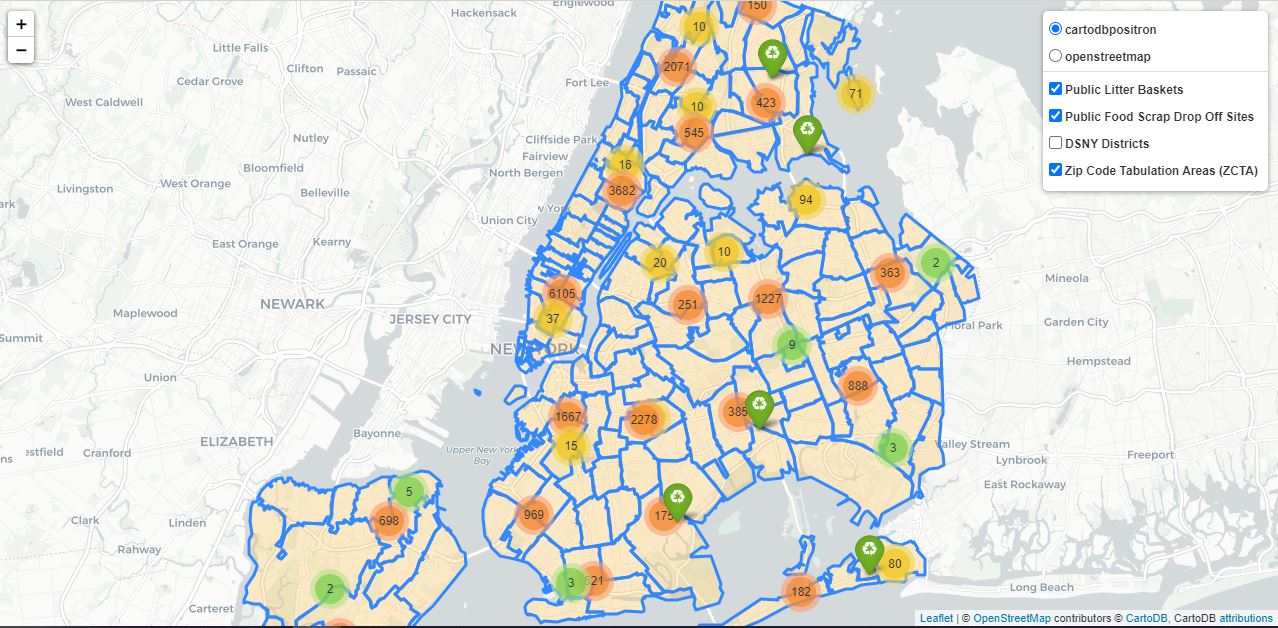

In [183]:
display(Image("/content/drive/MyDrive/DS_Project_Files/analysis_map.png"))

##Visualizing Data on Bakets and Food Scrap Sites
- Zip code to income
- Zip code to public litter baskets
- Zip code to food scrap sites

In [184]:
gdf = zipcode_income_basket_scrap_gdf
gdf = gdf.rename({"zip" : "zip_code"}, axis=1)
gdf["income_category"].replace({"N/A" : np.nan}, inplace=True)
gdf = gdf.dropna(subset=["income_category", "num_sites"])

#####Finding the twenty zip codes with the highest number of public litter baskets

In [185]:
highest_basket_gdf = gdf.sort_values("num_baskets", ascending=False)[:20]
highest_basket_gdf = highest_basket_gdf.reset_index(drop=True)
highest_basket_gdf["zip_code"] = highest_basket_gdf["zip_code"].astype(str)

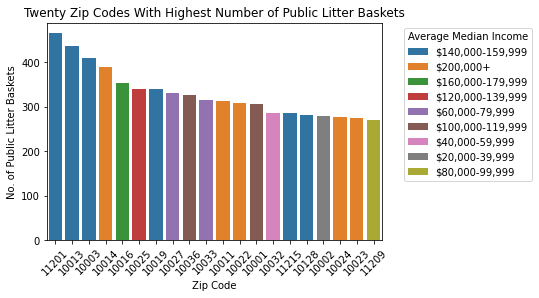

In [186]:
ax = sns.barplot(x="zip_code", y="num_baskets", hue="income_category", 
                 dodge=False, data=highest_basket_gdf)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set(xlabel="Zip Code", ylabel="No. of Public Litter Baskets", title="Twenty Zip Codes With Highest Number of Public Litter Baskets")
ax.legend(title="Average Median Income", bbox_to_anchor=(1.05, 1))
plt.savefig("Twenty_Highest_Num_of_Baskets.png", bbox_inches='tight', dpi=300)
plt.show()

##### In 2020, the median income in New York City was $68,304. 
From the analysis, there were only 2 zip codes whose income was less than the median were in the top 20. While there are over 23,000 litter baskets that was sorted by zip code, only 31.19% of them are in the low-income areas. 

In [187]:
plt.clf()

<Figure size 432x288 with 0 Axes>

######Creating a pie chart to show how food scrap sites are situated in the city with respect to incomes by zip code 

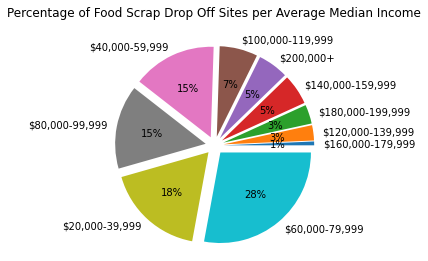

In [188]:
sites_gdf = gdf.assign()
sites_gdf = sites_gdf[["income_category", "num_sites"]]
sites_gdf = sites_gdf.groupby("income_category")["num_sites"].sum()
sites_gdf = sites_gdf.reset_index()
sites_gdf["percentage"] = (sites_gdf["num_sites"]/sites_gdf["num_sites"].sum()) * 100
sites_gdf = sites_gdf.sort_values("num_sites")
colors = sns.color_palette('tab10')[:10]
fig, ax3 = plt.subplots()
ax3.pie(sites_gdf["percentage"], colors=colors, labels=sites_gdf["income_category"], autopct='%.0f%%',
        explode=[0.1 for x in range(10)])
plt.axis('equal')
plt.title("Percentage of Food Scrap Drop Off Sites per Average Median Income", pad=20)
plt.savefig("Sites_per_Average_Median_Income.png", bbox_inches='tight', dpi=300)

#####  
From the analysis on DSNY districts, for each district there is at least one food scrap drop off site. However, based on zip code and income only 33% of all sites reside in lower-income neighborhoods. 

##Filtering Active Tobacco Retail Dealer Licenses Data
  

In [189]:
tobacco_df = pd.read_csv("/content/drive/MyDrive/DS_Project_Files/Active_Tobacco_Retail_Dealer_Licenses.csv")
tobacco_df

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,Secondary Address Street Name,Address City,Address State,Address ZIP,Contact Phone Number,Address Borough,Borough Code,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location
0,2066708-1-DCA,Business,12/31/2021,Active,02/23/2018,Tobacco Retail Dealer,BEER CAVE & MART CORP,NaN,601,E FORDHAM RD,NaN,BRONX,NY,10458,7185635950,Bronx,2,206.0,15.0,2016261.0,2.032730e+09,BX06,397.0,NaN,-73.885013,40.858393,"(40.85839261183536, -73.88501274569022)"
1,2040247-1-DCA,Business,12/31/2021,Active,07/13/2016,Tobacco Retail Dealer,madhuben patel,NaN,N/E/C,6 AVENUE,WEST 46 STREET,NEW YORK,NY,10036,2123025920,Manhattan,1,105.0,4.0,NaN,NaN,NaN,NaN,NaN,-73.982255,40.757388,"(40.75738784087671, -73.98225540711462)"
2,2095762-1-DCA,Business,12/31/2021,Active,05/28/2020,Tobacco Retail Dealer,DARDANIA MINI MART CORP,NaN,460,BRADLEY AVE,NaN,STATEN ISLAND,NY,10314,6463995622,Staten Island,5,502.0,49.0,5021261.0,5.008240e+09,NaN,NaN,NaN,-74.131016,40.599649,"(40.59964928525426, -74.13101638291955)"
3,1471302-DCA,Business,12/31/2022,Active,08/13/2013,Tobacco Retail Dealer,ME QUICK STOP GROCERY & CANDY CORP,NaN,4314,BROADWAY,NaN,NEW YORK,NY,10033,646-243-0757,Manhattan,1,112.0,10.0,1063930.0,1.021640e+09,MN35,271.0,NaN,-73.934852,40.851883,"(40.85188265950567, -73.9348524884686)"
4,1448067-DCA,Business,12/31/2021,Active,10/17/2012,Tobacco Retail Dealer,SUNSHINE EXPRESS DELI INC.,NaN,986A,GATES AVE,NaN,BROOKLYN,NY,11221,347-722-4832,Brooklyn,3,303.0,41.0,3332200.0,3.016380e+09,BK35,385.0,NaN,-73.924598,40.689196,"(40.68919570170771, -73.92459769250969)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5521,2080468-1-DCA,Business,12/31/2023,Active,12/05/2018,Tobacco Retail Dealer,322 EAST 34 INC,NaN,322,E 34TH ST,NaN,NEW YORK,NY,10016,347-261-4134,Manhattan,1,106.0,2.0,1021895.0,1.009390e+09,MN20,70.0,NaN,-73.974832,40.744332,"(40.74433243932285, -73.97483186707007)"
5522,2008501-1813-DCA,Business,12/31/2023,Active,05/22/2014,Tobacco Retail Dealer,1930 BARTOW AVE PETROLEUM LLC,NaN,1930,BARTOW AVE,NaN,BRONX,NY,10469,914-699-9500,Bronx,2,212.0,12.0,2088093.0,2.048040e+09,BX03,356.0,NaN,-73.833857,40.868088,"(40.868087705097544, -73.833857321179)"
5523,2052175-2-DCA,Business,12/31/2022,Active,05/01/2017,Tobacco Retail Dealer,FRANKY DELI AND GROCERY CORP,NaN,2962,AVENUE X,NaN,BROOKLYN,NY,11235,631-703-4124,Brooklyn,3,315.0,48.0,3203614.0,3.074230e+09,BK17,596.0,NaN,-73.939277,40.593955,"(40.59395482629597, -73.93927737639939)"
5524,2097415-1-DCA,Business,12/31/2023,Active,01/05/2021,Tobacco Retail Dealer,TREMONT 9 STAR GOURMET CORP,NaN,303,E TREMONT AVE,NaN,BRONX,NY,10457,3473027479,Bronx,2,205.0,15.0,2007762.0,2.028140e+09,NaN,NaN,NaN,-73.903091,40.848663,"(40.8486627690614, -73.90309129575996)"


#####Grouping the data by the zip code to be compared to the other features 
- Getting the sum of the number of dealers with active licenses in a zip code
- Merging with the main geodataframe

In [190]:
query = """
SELECT "Address ZIP" as zip, COUNT("Business Name") AS num_tobacco_dealers
FROM tobacco_df
GROUP BY "Address ZIP"
"""
grouped_tobacco_df = psql.sqldf(query)
zip_income_sanitation_tobacco_gdf = pd.merge(zipcode_income_basket_scrap_gdf, grouped_tobacco_df, how="left", on="zip")
zip_income_sanitation_tobacco_gdf

,zip,county,longitude,latitude,geometry,income_category,income,num_baskets,num_sites,district,num_tobacco_dealers
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.50,307.0,2.0,MN04,65.0
1,10002,New York County,-73.99,40.71,"POLYGON ((-73.99750 40.71407, -73.99709 40.714...","$20,000-39,999",38186.50,280.0,2.0,MN03,57.0
2,10003,New York County,-73.99,40.73,"POLYGON ((-73.99937 40.73132, -73.99911 40.731...","$140,000-159,999",147884.50,410.0,2.0,MN06,52.0
3,10004,New York County,-74.02,40.69,"MULTIPOLYGON (((-74.01769 40.70386, -74.01765 ...","$180,000-199,999",187728.75,61.0,5.0,MN01,19.0
4,10005,New York County,-74.01,40.71,"POLYGON ((-74.01251 40.70677, -74.01195 40.707...","$200,000+",inf,41.0,0.0,NaN,17.0
...,...,...,...,...,...,...,...,...,...,...,...
206,11691,Queens County,-73.76,40.60,"POLYGON ((-73.78926 40.59651, -73.78925 40.596...","$40,000-59,999",53630.00,73.0,1.0,QE14,20.0
207,11692,Queens County,-73.79,40.59,"POLYGON ((-73.80533 40.59052, -73.80452 40.590...","$40,000-59,999",55480.50,32.0,0.0,QE14,5.0
208,11693,Queens County,-73.81,40.59,"MULTIPOLYGON (((-73.82009 40.58698, -73.81936 ...","$60,000-79,999",63545.25,57.0,0.0,QE14,12.0
209,11694,Queens County,-73.84,40.58,"POLYGON ((-73.88305 40.56838, -73.88294 40.568...","$80,000-99,999",95200.00,99.0,0.0,QE14,18.0


##Monthly Tonnage Data Cleaning & Filtering 

In [191]:
tonnage_df = pd.read_csv("/content/drive/MyDrive/DS_Project_Files/DSNY_Monthly_Tonnage_Data.csv")
tonnage_df

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID
0,2021 / 05,Brooklyn,07,3421.6,400.8,389.0,NaN,NaN,NaN,NaN,3.0
1,2021 / 08,Brooklyn,07,3517.7,414.8,385.5,NaN,NaN,NaN,NaN,3.0
2,2021 / 11,Brooklyn,07,747.3,92.5,87.2,NaN,NaN,NaN,NaN,3.0
3,2021 / 11,Queens,05,1153.7,134.5,148.2,NaN,NaN,NaN,NaN,4.0
4,2021 / 03,Queens,13,5640.0,455.7,950.8,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...
645,2021 / 01,Manhattan,01,1175.8,385.3,267.6,NaN,NaN,NaN,27.3,1.0
646,2021 / 08,Manhattan,01,1254.9,352.8,208.5,NaN,NaN,NaN,NaN,1.0
647,2021 / 09,Manhattan,01,1371.9,461.2,240.3,NaN,NaN,NaN,NaN,1.0
648,2021 / 03,Bronx,03,2298.9,193.1,239.3,NaN,NaN,NaN,NaN,2.0


#####No DSNY district to compare with the rest of the data
- Using pandas any() to see if there is the correct prefix for the district name

In [192]:
sanitationdistricts = []
for x in tonnage_df.index:
    district = str(tonnage_df.loc[x, "COMMUNITYDISTRICT"])
    if len(district) == 1:
        district = "0" + district
    borough = tonnage_df.loc[x, "BOROUGH"]
    if borough == "Manhattan":
        sanitationdistricts.append("MN" + district)
    elif borough == "Bronx":
        sanitationdistricts.append("BX" + district)
    elif borough == "Staten Island":
        sanitationdistricts.append("SI" + district)
    elif borough == "Queens":
        if (dsny_districts_gdf["district"].isin(["QE" + district]).any().any()):
            sanitationdistricts.append("QE" + district)
        else:
            sanitationdistricts.append("QW" + district)
    elif borough == "Brooklyn":
        if (dsny_districts_gdf["district"].isin(["BKE" + district]).any().any()):
            sanitationdistricts.append("BKE" + district)
        elif (dsny_districts_gdf["district"].isin(["BKN" + district]).any().any()):
            sanitationdistricts.append("BKN" + district)
        elif (dsny_districts_gdf["district"].isin(["BKS" + district]).any().any()):
            sanitationdistricts.append("BKS" + district)
        else:
            sanitationdistricts.append("BKW" + district)

#####Add the district column to the tonnage dataframe and drop unnecessary columns

In [193]:
tonnage_df["district"] = pd.Series(sanitationdistricts)
tonnage_df = tonnage_df.drop(["MONTH", "BOROUGH", "COMMUNITYDISTRICT", 
                              "RESORGANICSTONS", "SCHOOLORGANICTONS", 
                              "LEAVESORGANICTONS", "XMASTREETONS", 
                              "BOROUGH_ID"], axis=1)
tonnage_df

,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,district
0,3421.6,400.8,389.0,BKS07
1,3517.7,414.8,385.5,BKS07
2,747.3,92.5,87.2,BKS07
3,1153.7,134.5,148.2,QW05
4,5640.0,455.7,950.8,QE13
...,...,...,...,...
645,1175.8,385.3,267.6,MN01
646,1254.9,352.8,208.5,MN01
647,1371.9,461.2,240.3,MN01
648,2298.9,193.1,239.3,BX03


######Merge tonnage dataframe with the DSNY district geodataframe

In [194]:
dsny_district_tonnage_df = pd.merge(districts_gdf, tonnage_df, how="left", on="district")
dsny_district_tonnage_df

,district,districtco,fid,globalid,shape_area,shape_leng,geometry,zipcode,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED
0,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6151.9,760.8,758.3
1,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6586.2,750.1,784.7
2,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6115.6,695.9,697.6
3,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6995.0,834.7,826.5
4,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6554.4,794.9,771.9
...,...,...,...,...,...,...,...,...,...,...,...
644,BKS11,311,1,{857F750E-F050-472E-A3E8-449008357B98},0.001020,0.164766,"POLYGON ((-73.97300 40.60882, -73.97259 40.606...","[11204, 11209, 11214, 11219, 11223, 11228, 11230]",1104.9,131.8,121.8
645,BKS11,311,1,{857F750E-F050-472E-A3E8-449008357B98},0.001020,0.164766,"POLYGON ((-73.97300 40.60882, -73.97259 40.606...","[11204, 11209, 11214, 11219, 11223, 11228, 11230]",5612.8,598.2,547.7
646,BKS11,311,1,{857F750E-F050-472E-A3E8-449008357B98},0.001020,0.164766,"POLYGON ((-73.97300 40.60882, -73.97259 40.606...","[11204, 11209, 11214, 11219, 11223, 11228, 11230]",4938.4,608.5,598.6
647,BKS11,311,1,{857F750E-F050-472E-A3E8-449008357B98},0.001020,0.164766,"POLYGON ((-73.97300 40.60882, -73.97259 40.606...","[11204, 11209, 11214, 11219, 11223, 11228, 11230]",5422.6,562.6,528.4


######Creating a function to determine which districts has a food scrap drop off site
- Apply the function as the "hasSite" column to the district tonnage dataframe

In [195]:
def zipScrapSite(ziplist):
    if (grouped_scraps_gdf.isin(ziplist).any().any()):
        return True
    return False

dsny_district_tonnage_df["hasSite"] = dsny_district_tonnage_df["zipcode"].apply(zipScrapSite)
dsny_district_tonnage_df

,district,districtco,fid,globalid,shape_area,shape_leng,geometry,zipcode,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,hasSite
0,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6151.9,760.8,758.3,True
1,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6586.2,750.1,784.7,True
2,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6115.6,695.9,697.6,True
3,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6995.0,834.7,826.5,True
4,SI03,503,111,{39F3B701-E1E4-4D24-9E7A-D12AF02CD8DF},0.005915,0.575665,"POLYGON ((-74.20073 40.57933, -74.19930 40.579...","[10306, 10307, 10308, 10309, 10312, 10314]",6554.4,794.9,771.9,True
...,...,...,...,...,...,...,...,...,...,...,...,...
644,BKS11,311,1,{857F750E-F050-472E-A3E8-449008357B98},0.001020,0.164766,"POLYGON ((-73.97300 40.60882, -73.97259 40.606...","[11204, 11209, 11214, 11219, 11223, 11228, 11230]",1104.9,131.8,121.8,True
645,BKS11,311,1,{857F750E-F050-472E-A3E8-449008357B98},0.001020,0.164766,"POLYGON ((-73.97300 40.60882, -73.97259 40.606...","[11204, 11209, 11214, 11219, 11223, 11228, 11230]",5612.8,598.2,547.7,True
646,BKS11,311,1,{857F750E-F050-472E-A3E8-449008357B98},0.001020,0.164766,"POLYGON ((-73.97300 40.60882, -73.97259 40.606...","[11204, 11209, 11214, 11219, 11223, 11228, 11230]",4938.4,608.5,598.6,True
647,BKS11,311,1,{857F750E-F050-472E-A3E8-449008357B98},0.001020,0.164766,"POLYGON ((-73.97300 40.60882, -73.97259 40.606...","[11204, 11209, 11214, 11219, 11223, 11228, 11230]",5422.6,562.6,528.4,True


#####Merging the tonnage dataframe with the main geodataframe

In [196]:
zip_income_sanitation_tobacco_gdf = pd.merge(zip_income_sanitation_tobacco_gdf, tonnage_df, how="left", on="district")
zip_income_sanitation_tobacco_gdf

,zip,county,longitude,latitude,geometry,income_category,income,num_baskets,num_sites,district,num_tobacco_dealers,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2308.8,454.0,384.5
1,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2251.4,505.3,385.3
2,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2494.0,558.0,400.4
3,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2041.3,453.7,342.0
4,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2487.0,614.3,386.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,11697,Queens County,-73.91,40.56,"POLYGON ((-73.94074 40.54182, -73.94013 40.548...","$100,000-119,999",108852.0,0.0,0.0,QE14,1.0,698.0,50.1,50.9
2047,11697,Queens County,-73.91,40.56,"POLYGON ((-73.94074 40.54182, -73.94013 40.548...","$100,000-119,999",108852.0,0.0,0.0,QE14,1.0,3648.4,257.7,270.8
2048,11697,Queens County,-73.91,40.56,"POLYGON ((-73.94074 40.54182, -73.94013 40.548...","$100,000-119,999",108852.0,0.0,0.0,QE14,1.0,3850.4,273.9,307.6
2049,11697,Queens County,-73.91,40.56,"POLYGON ((-73.94074 40.54182, -73.94013 40.548...","$100,000-119,999",108852.0,0.0,0.0,QE14,1.0,3419.0,254.8,300.2


##Scorecard Ratings Filtering

In [197]:
scorecard_df = pd.read_csv("/content/drive/MyDrive/DS_Project_Files/Scorecard_Ratings.csv")

#####Filtered scorecard dataframe to the district, cleaning section, and % of acceptable sidewalks and streets

In [198]:
scorecard_df = scorecard_df.drop(["Month", "Borough", "Community Board", 
                             "Acceptable Streets % - Previous Month", 
                             "Acceptable Sidewalks % - Previous Month",
                              "Acceptable Streets % - Previous Year", 
                              "Acceptable Sidewalks % - Previous Year",
                              "Acceptable Streets % - Previous Fiscal Quarter", 
                              "Acceptable Sidewalks % - Previous Fiscal Quarter"], axis=1)
scorecard_df

,District,Cleaning Section,Acceptable Streets %,Acceptable Sidewalks %
0,MN01,MN011,NaN,NaN
1,MN01,MN013,100.0,100.0
2,MN01,Unspecified,NaN,NaN
3,MN10,MN101,64.0,80.0
4,MN10,MN103,69.6,91.3
...,...,...,...,...
224,SI02,SI024,100.0,100.0
225,SI03,SI031,100.0,100.0
226,SI03,SI032,100.0,100.0
227,SI03,SI033,100.0,100.0


#####Grouping scorecard ratings bt district

In [199]:
grouped_scorecard_df = scorecard_df.groupby("District").mean()
grouped_scorecard_df.reset_index(inplace=True)
grouped_scorecard_df = grouped_scorecard_df.rename({"District" : "district"}, axis=1)
grouped_scorecard_df

,district,Acceptable Streets %,Acceptable Sidewalks %
0,BKN01,89.866667,92.166667
1,BKN02,98.500000,100.000000
2,BKN03,67.033333,91.633333
3,BKN04,93.233333,92.500000
4,BKN05,92.700000,89.300000
5,BKN08,69.050000,97.000000
6,BKN09,83.300000,87.500000
7,BKN16,NaN,NaN
8,BKN17,98.033333,93.700000
9,BKS06,100.000000,100.000000


#####Merge with main geodataframe for the correlation analysis

In [200]:
zip_income_sanitation_tobacco_gdf = pd.merge(zip_income_sanitation_tobacco_gdf, grouped_scorecard_df, how= "left", on="district")
zip_income_sanitation_tobacco_gdf

,zip,county,longitude,latitude,geometry,income_category,income,num_baskets,num_sites,district,num_tobacco_dealers,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,Acceptable Streets %,Acceptable Sidewalks %
0,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2308.8,454.0,384.5,94.866667,96.366667
1,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2251.4,505.3,385.3,94.866667,96.366667
2,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2494.0,558.0,400.4,94.866667,96.366667
3,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2041.3,453.7,342.0,94.866667,96.366667
4,10001,New York County,-74.00,40.75,"POLYGON ((-74.00979 40.75308, -74.00832 40.752...","$100,000-119,999",115079.5,307.0,2.0,MN04,65.0,2487.0,614.3,386.4,94.866667,96.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,11697,Queens County,-73.91,40.56,"POLYGON ((-73.94074 40.54182, -73.94013 40.548...","$100,000-119,999",108852.0,0.0,0.0,QE14,1.0,698.0,50.1,50.9,NaN,NaN
2047,11697,Queens County,-73.91,40.56,"POLYGON ((-73.94074 40.54182, -73.94013 40.548...","$100,000-119,999",108852.0,0.0,0.0,QE14,1.0,3648.4,257.7,270.8,NaN,NaN
2048,11697,Queens County,-73.91,40.56,"POLYGON ((-73.94074 40.54182, -73.94013 40.548...","$100,000-119,999",108852.0,0.0,0.0,QE14,1.0,3850.4,273.9,307.6,NaN,NaN
2049,11697,Queens County,-73.91,40.56,"POLYGON ((-73.94074 40.54182, -73.94013 40.548...","$100,000-119,999",108852.0,0.0,0.0,QE14,1.0,3419.0,254.8,300.2,NaN,NaN


##Analysis and Visualizing Correlation Data

#####Creating a heatmap from correlation matrix
- Specifically using a Pearson correlation since we wish to measure the linear relationship between the features

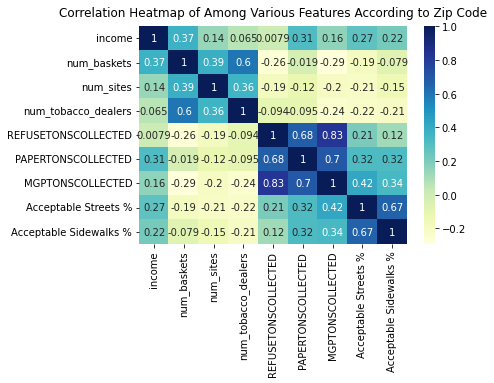

In [288]:
correlation_gdf = zip_income_sanitation_tobacco_gdf.assign().drop(["zip", "longitude", "latitude"], axis=1).replace(np.Inf, np.nan).dropna()
correlation_gdf["income"] = correlation_gdf["income"].dropna()
sns.heatmap(correlation_gdf.corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Heatmap of Among Various Features According to Zip Code", pad=10)
plt.savefig("CorrelationHeatmap.png", bbox_inches="tight")

#####From the heatmap matrix, we can observe that there 0.60 correlation value between num_tobacco_dealers (# of cigarette retail sellers) and num_baskets (# of public litter baskets) by zip code
#####Let's build a simple regression model using sklearn's train_test_split() and statsmodel's Ordinary Least Squares (OLS)

In [289]:
plt.clf()
X = correlation_gdf["num_tobacco_dealers"]
y = correlation_gdf["num_baskets"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=25)

<Figure size 432x288 with 0 Axes>

####Adding a constant to get an intercept & fitting our model

In [290]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            num_baskets   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     718.0
Date:                Fri, 10 Dec 2021   Prob (F-statistic):          1.81e-125
Time:                        23:44:43   Log-Likelihood:                -7275.1
No. Observations:                1258   AIC:                         1.455e+04
Df Residuals:                    1256   BIC:                         1.456e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  36.7185      4.110      8.934      0.000      28.656      44.781
num_tobacco_dealers     2.9705      0.111     26.796      0.000       2.753       3.188
==============================================================================
Omnibus:                      282.446   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              756.760
Skew:                           1.162   Prob(JB):                    4.70e-165
Kurtosis:                       6.006   Cond. No.                         68.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#####From here, we notice that the R-squared value is 0.364, which means that the number of cigarette dealers only accounts for 36.4% of the variance for number of public litter baskets
#####Let's plot the linear regression model with seaborn relplot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



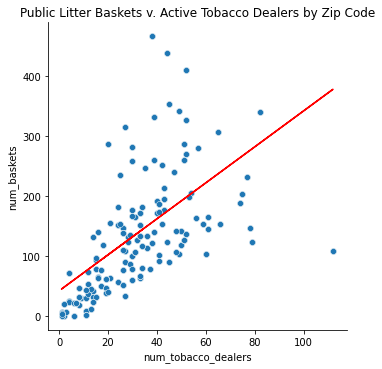

In [294]:
ax = sns.relplot(X_train, y_train)
ax.set(title="Public Litter Baskets v. Active Tobacco Dealers by Zip Code")
plt.plot(X_train, 41.8898 + 3*X_train, 'r')
plt.savefig("Basket_Cigarette_linearreg.png", bbox_inches="tight")

#####While the regression doesn't seem to cover most of the points, the weight of the points above the line changes the best fit


##Conclusion
From the analysis conducted in the project, I can conclude that my original hypothesis was mostly false. While lower-income areas contain 31.19% of litter baskets and 33% of food scrap sites, it does not mean there is a strong relationship between that and sanitation factors. From the correlation matrix and the linear regression model demonstrates that income does not attribute to these factors. This means to look further into this question, other factors must be studied and analyze to look further. 

##Citations

###Open Datasets
- DSNY Monthly Tonnage - https://data.cityofnewyork.us/City-Government/DSNY-Monthly-Tonnage-Data/ebb7-mvp5 
- DSNY Districts - https://data.cityofnewyork.us/City-Government/DSNY-Districts/i6mn-amj2 
- DSNY Food Scrap Drop Off Locations - https://data.cityofnewyork.us/Environment/Food-Scrap-Drop-Off-Locations-in-NYC-Map-/qfn2-4jea 
- DSNY Litter Basket Inventory - https://data.cityofnewyork.us/dataset/DSNY-Litter-Basket-Inventory/8znf-7b2c 
- American Community Survey (ACS) 2019 Income In The Past 12 Months (5-Year Estimates) -  https://data.census.gov/cedsci/table?q=median%20income&tid=ACSST1Y2019.S1901 
- U.S. Census ZCTA - https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html
- Active Tobacco Retail Dealer Licenses - https://data.cityofnewyork.us/Business/Active-Tobacco-Retail-Dealer-Licenses/adw8-wvxb/data 
- Scorecard Ratings - https://data.cityofnewyork.us/City-Government/Scorecard-Ratings/rqhp-hivt 
- U.S. Postal Service Zip Code Database - https://www.unitedstateszipcodes.org/ny/ 

### Analysis Resources
- Building a Simple Linear Regression Model - https://towardsdatascience.com/simple-linear-regression-model-using-python-machine-learning-eab7924d18b4
- Marker Clusters in Folium Maps - https://www.jpytr.com/post/analysinggeographicdatawithfolium/
- Pandas Library Documentation - https://pandas.pydata.org/
- Matplotlib Library Documentation - https://matplotlib.org/
- Folium Library Documentation - https://python-visualization.github.io/folium/index.html

### Research Resources
- NYPLI Waste Report https://www.nylpi.org/waste-report-new-yorks-poorer-neighborhoods-are-getting-dumped-on/
- Mayor de Blasio's Sanitation Initatives - https://www1.nyc.gov/office-of-the-mayor/news/230-21/recovery-all-us-mayor-de-blasio-new-york-city-department-sanitation-new 

